In [35]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from numpy import *

from ggplot import *
from scipy.stats import logistic
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from linearmodels.iv import IV2SLS
from scipy import stats
from scipy.stats import trim_mean #trimmed mean
from scipy.stats import * #chi2_contingency로 카이제곱통계량계산
from scipy.stats import norm

import keyword
import random

#open api 불러올 때 필요한 것
from urllib.request import urlopen #request package 설치
from bs4 import BeautifulSoup #bs4 package 설치

# 그래프에서 한글 깨지지 않기 위헤 사용함
from matplotlib import rcParams
from matplotlib import font_manager,rc

rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='Malgun Gothic'
font_name=font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family=font_name)

import FinanceDataReader as fdr
import plotly.graph_objects as go
import plotly.subplots as ms
import math



# LN9 소득 차이에 대한 검정(2)
## 3 성별, 직업군별 소득 차이 검정

- 두 범주형 변수가 서로 독립인지 카이분포를 사용해서 가설검정해보기
- 범주 1: 성별 (남, 여) / 범주 2: 지지정당 (보수, 진보)
- 표 나오겠지..
- 직업 10가지 -> 범주 10개
- 귀무가설: 남녀 간 직업의 차이는 독립이다. (남녀 간의 직업의 차이는 우연에 지나지 않는다)
- 대립가설: 남녀 간 차이가 직업에 영향을 미친다 (남녀 간의 직업 차이는 실질적이다.)
- > 카이제곱검정 사용!
- 먼저 frequency table 만듦
- 그다음 귀무가설 아래 카이제곱 계산
- 여기서 기대도수는 뭐냐?!

In [36]:
df=pd.read_csv('c:/temp/household_2020a.csv')
df.head()

,year,metro,id,sex,age,number,education,marriage,asset,debt,income,income_d,industry,job,house
0,2020,G1,10000112,1,34,3,6,2,112000,54500,6593,4599,F,3,2
1,2020,G1,10000132,2,45,2,8,2,42500,17500,17720,15257,J,2,3
2,2020,G1,10000162,2,73,1,2,3,5712,0,908,725,T,4,2
3,2020,G1,10000182,1,58,2,4,2,14870,0,2748,2431,C,5,2
4,2020,G1,10000192,2,27,1,4,1,814,0,1015,893,R,2,3


In [37]:
pd.value_counts(df['job'])

2    2043
3    1959
8    1919
9    1904
7    1455
6    1217
5    1205
4    1159
1     328
A      25
Name: job, dtype: int64

In [38]:
df1=df[['sex','job']]
df1=df1.dropna()

In [39]:
# A 군인은 남자가 압도겆으로 많을 테니 a가진 사람 다 지우자
df2=df1.loc[df1['job']!='A']  # !='A' : 앞에 있는 거랑 A랑 같지 '않은' 것만 남겨라
pd.value_counts(df2['job'])

2    2043
3    1959
8    1919
9    1904
7    1455
6    1217
5    1205
4    1159
1     328
Name: job, dtype: int64

In [40]:
# a 사라짐

In [41]:
# 가설검정을 위해 첫번째 할 일 : two-way frequency table을 만든다
pd.crosstab(df2['sex'],df2['job'])

job,1,2,3,4,5,6,7,8,9
sex,,,,,,,,,
1,316,1623,1644,558,882,1020,1379,1832,1318
2,12,420,315,601,323,197,76,87,586


In [42]:
pd.crosstab(df2['sex'],df2['job'],margins=True) # All 칼럼 하나 더 나옴 ( 다 더한 값)

job,1,2,3,4,5,6,7,8,9,All
sex,,,,,,,,,,
1,316,1623,1644,558,882,1020,1379,1832,1318,10572
2,12,420,315,601,323,197,76,87,586,2617
All,328,2043,1959,1159,1205,1217,1455,1919,1904,13189


In [43]:
# 위에 표가 관측도수
# 기대도수는 뭐냐?!!
# 가설검정을 위해 2번째 할 일 : 카이제곱 검정통계량을 계산한다

In [44]:
# 남녀간 직업 차이가 없다면 남자,여자들은 n번 job을 몇명이나 가질까? <- 기대도수
# ex. 1번 job 가질 비율

# 남자의 1번 직업 기대도수
10572*(328/13189)

262.91727955114106

In [45]:
# 여자의 1번 직업 기대도수
2617*(328/13189)

65.0827204488589

In [46]:
# 가설검정을 위해 3번째 할 일 : 카이제곱 검정통계량의 p-value를 계산하여 p-value<0.05이면 귀무가설을 기각한다

# 이 경우 카이제곱 자유도

# chi2_crntingency 함수를 사용하기 위해서는 먼저 pd.crosstab의 결과를 data frame으로 저장해야 한다.
# 이때 반드시 'all(margins=True)'는 빼고 저장해야함
cross_tab1=pd.crosstab(df2['sex'],df2['job'])

In [47]:
cross_tab1

job,1,2,3,4,5,6,7,8,9
sex,,,,,,,,,
1,316,1623,1644,558,882,1020,1379,1832,1318
2,12,420,315,601,323,197,76,87,586


In [48]:
# chi2_contingency 함수를 사용하면 아래 네개 값이 나옴
# chi2: 카이 가설 검정 통계량
# p: p value
# dof: 자유도
# expected: 기대도수
chi_2,p,dof,expected=chi2_contingency(cross_tab1)

In [49]:
# 기대도수를 위에 처럼 일일이 계산하지 말고 파이썬으로 그냥 보여줘
print(expected)

[[ 262.91727955 1637.62195769 1570.28948366  929.02782622  965.90037152
   975.51929638 1166.29463947 1538.22640079 1526.20274471]
 [  65.08272045  405.37804231  388.71051634  229.97217378  239.09962848
   241.48070362  288.70536053  380.77359921  377.79725529]]


In [50]:
print(dof)

8


In [51]:
print(chi_2)

1487.2418760780276


In [53]:
# p-value 는 다음과 같이 계산한다
1-chi2.cdf(chi_2,8)

0.0

In [54]:
# p-value가 0.05보다 작다 -> 귀무가설 기각

In [55]:
# 사실 'p'에 저장되어있음
print(p)

0.0


In [57]:
 # 같은 결과 나옴

In [58]:
# python 코드 이용해서 카이제곱 분포의 pdf 생성해보자

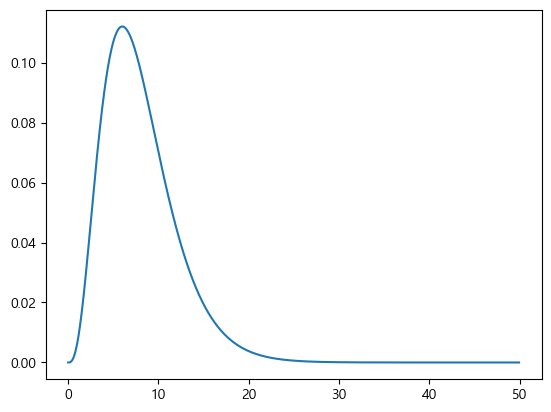

In [59]:
# 카이제곱 분포의 PDF with DOF=8
x=np.arange(0,50,0.05) # x값 만들기: 0부터 50까지 0.05 간격으로 x값 만들기
DoF=8 # 자유도는 8로 지정
plt.plot(x,chi2.pdf(x,DoF))
plt.show()

# LN10 : 회귀분석(1)
## 1 회귀분석 방법: simple linear regression
- 필기하기
## 2 소득과 순자산 간 관계
- 다음시간에 이어서